In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

# Rule-based algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [4]:
df = pd.read_excel('data.xlsx')
df.head()

,CustomerID,Name,Age,Email,EmploymentStatus,HousingStatus,ActiveMember,Country,EstimatedSalary,Balance,...,CustomerEngagementScore,TechSupportTicketCount,NumberOfAppCrashes,NavigationDifficulty,UserFrustration,CustomerSatisfactionSurvey,CustomerServiceCalls,NPS,Churn,Persona
0,15634602,Wyatt Miller,27,wyatt.miller47@gmail.com,0,1,1,Singapore,56424,85123.46,...,10,0,0,0,0,3,1,9,0,Opportunistic
1,15634603,Kathleen Coleman,27,kathleen.coleman79@gmail.com,0,1,1,Singapore,70079,51061.66,...,2,0,0,0,0,3,4,10,0,General
2,15634604,Mrs. Suzanne Torres MD,48,mrs..md62@gmail.com,1,1,1,Singapore,87211,86096.84,...,4,1,2,6,1,9,2,2,1,TechDifficulties
3,15634605,Christian Hoffman,64,christian.hoffman3@gmail.com,1,0,1,Singapore,79491,118453.65,...,9,0,0,0,0,8,2,7,0,Loyal
4,15634606,Marcus Henson,34,marcus.henson49@gmail.com,0,0,1,Singapore,73618,73389.26,...,10,2,2,6,1,10,1,6,0,TechDifficulties


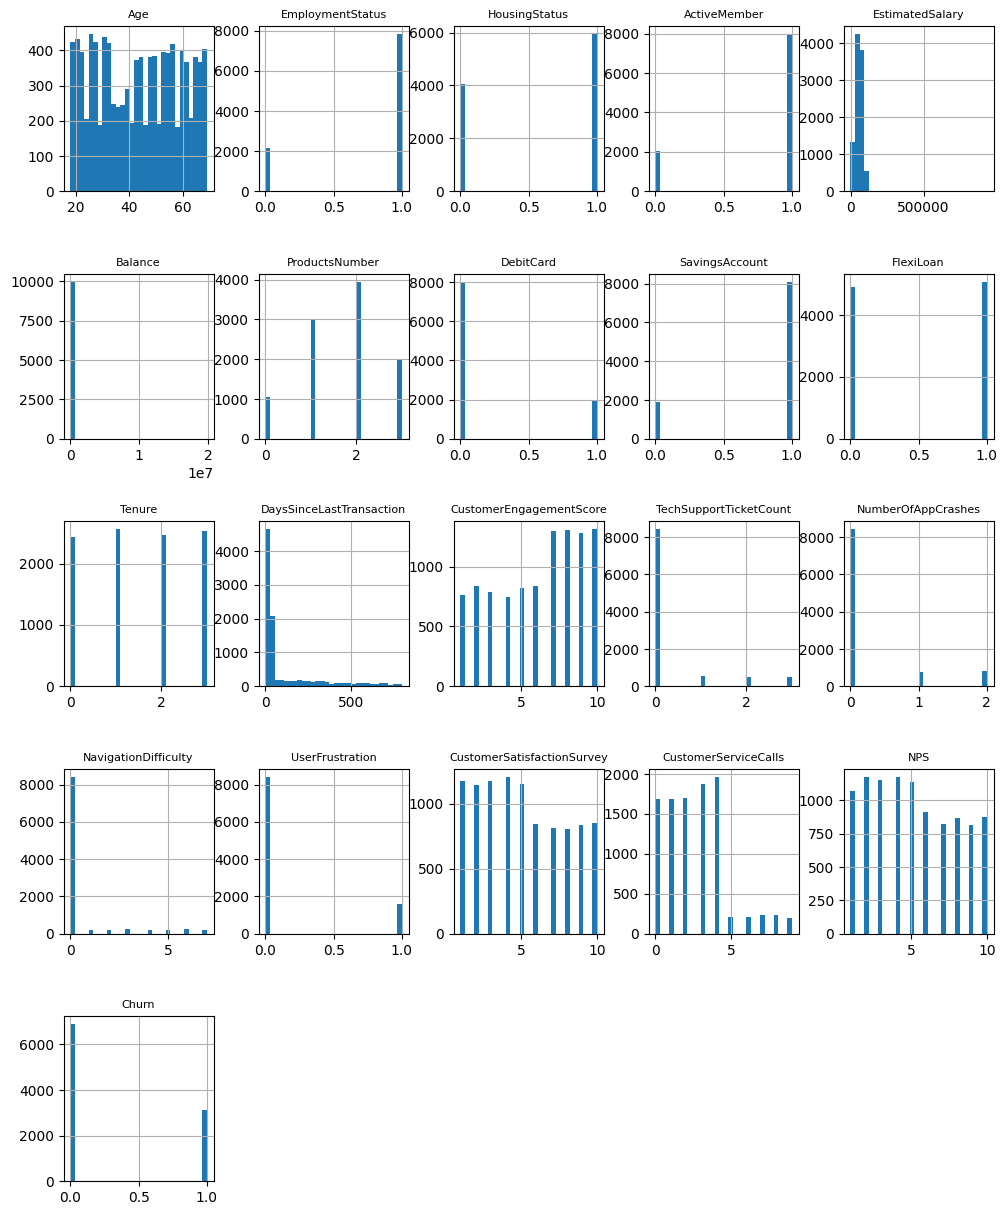

In [56]:
data_cleaned_2 = df.drop(columns=['CustomerID', 'Name', 'Email'])
data_cleaned_2.hist(bins=30, figsize=(12, 15))
plt.subplots_adjust(hspace=0.5)
# Loop over all axes to set the font size
for ax in plt.gcf().get_axes():
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(10)  # Set font size to 10
        ax.title.set_fontsize(8)

plt.show()

clean data and data preprocessing

In [15]:
import joblib
print("Available columns in dataset:", df.columns.tolist())
# Ensure 'Persona' column exists
data_cleaned = df.drop(columns=['CustomerID', 'Name', 'Email', 'Churn'])
# print("Columns after removing unnecessary ones:", data_cleaned.columns.tolist())
data_cleaned = data_cleaned[~data_cleaned['Persona'].isin([ 'Key Accounts'])]

X = data_cleaned.drop(columns='Persona')  # Drop the target variable from the features
y = data_cleaned['Persona']
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
print("Numeric columns:", numeric_columns)
print("Categorical columns:", categorical_columns)

Available columns in dataset: ['CustomerID', 'Name', 'Age', 'Email', 'EmploymentStatus', 'HousingStatus', 'ActiveMember', 'Country', 'EstimatedSalary', 'Balance', 'Gender', 'ProductsNumber', 'DebitCard', 'SavingsAccount', 'FlexiLoan', 'Tenure', 'DaysSinceLastTransaction', 'CustomerEngagementScore', 'TechSupportTicketCount', 'NumberOfAppCrashes', 'NavigationDifficulty', 'UserFrustration', 'CustomerSatisfactionSurvey', 'CustomerServiceCalls', 'NPS', 'Churn', 'Persona']
Numeric columns: ['Age', 'EmploymentStatus', 'HousingStatus', 'ActiveMember', 'EstimatedSalary', 'Balance', 'ProductsNumber', 'DebitCard', 'SavingsAccount', 'FlexiLoan', 'Tenure', 'DaysSinceLastTransaction', 'CustomerEngagementScore', 'TechSupportTicketCount', 'NumberOfAppCrashes', 'NavigationDifficulty', 'UserFrustration', 'CustomerSatisfactionSurvey', 'CustomerServiceCalls', 'NPS']
Categorical columns: ['Country', 'Gender']


['preprocessor.pkl']

In [43]:
data_cleaned.dtypes

Age                             int64
EmploymentStatus                int64
HousingStatus                   int64
ActiveMember                    int64
Country                        object
EstimatedSalary                 int64
Balance                       float64
Gender                         object
ProductsNumber                  int64
DebitCard                       int64
SavingsAccount                  int64
FlexiLoan                       int64
Tenure                          int64
DaysSinceLastTransaction        int64
CustomerEngagementScore         int64
TechSupportTicketCount          int64
NumberOfAppCrashes              int64
NavigationDifficulty            int64
UserFrustration                 int64
CustomerSatisfactionSurvey      int64
CustomerServiceCalls            int64
NPS                             int64
Persona                        object
dtype: object

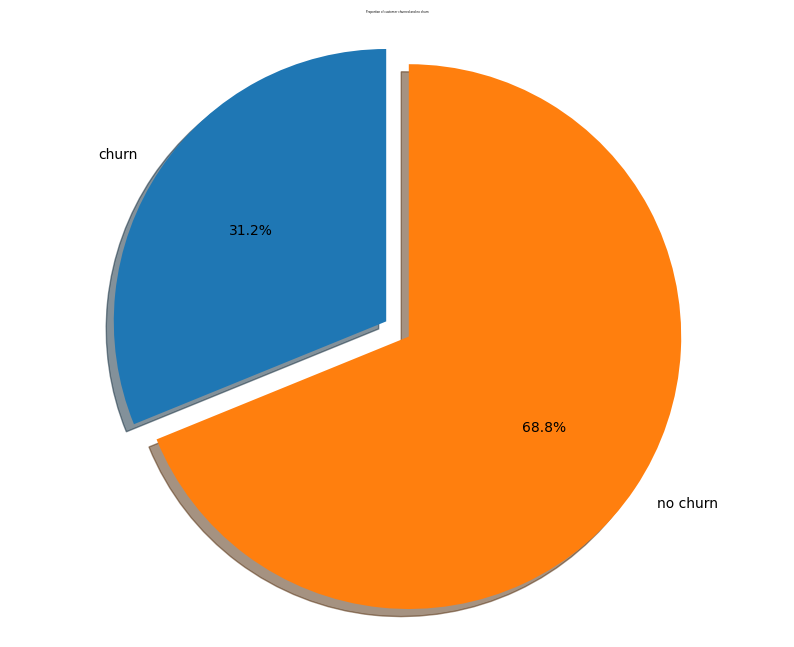

In [44]:
#exploratory data analysis
labels = 'churn', 'no churn'
sizes = [df.Churn[df['Churn']==1].count(), df.Churn[df['Churn']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and no churn", size = 2)
plt.show()

<Axes: xlabel='UserFrustration', ylabel='count'>

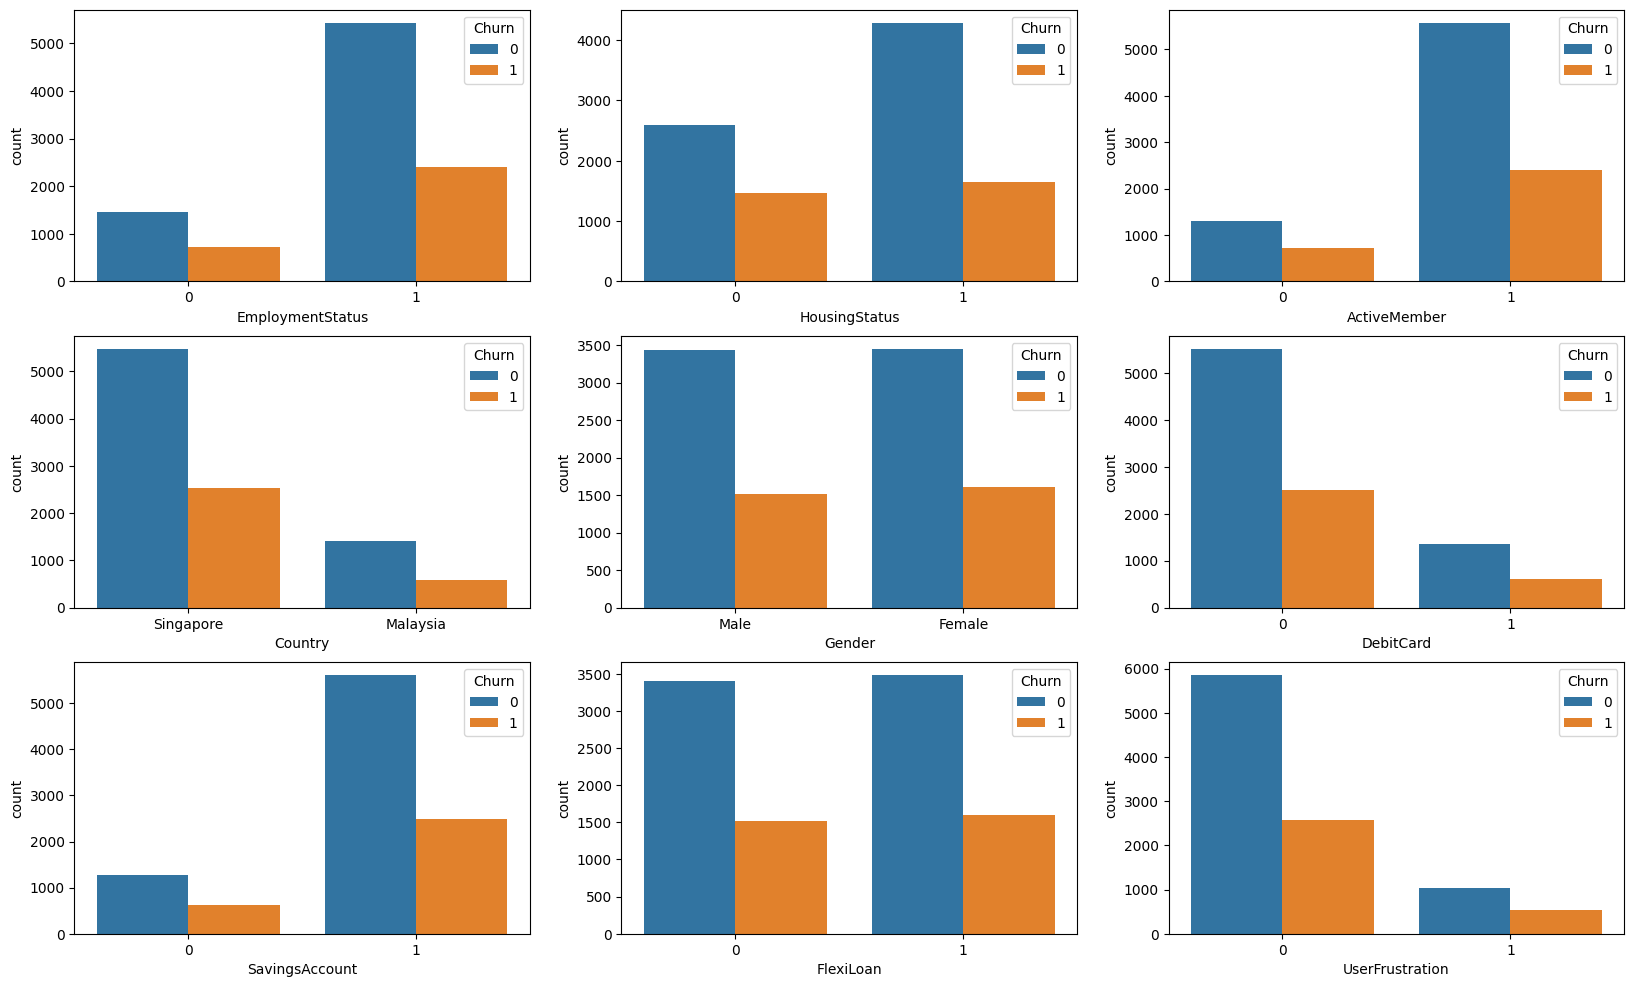

In [45]:
#eda - looking at categorical features
fig, axarr = plt.subplots(3, 3, figsize=(20, 12))
sns.countplot(x='EmploymentStatus', hue = 'Churn',data = df, ax=axarr[0][0])
sns.countplot(x='HousingStatus', hue = 'Churn',data = df, ax=axarr[0][1])
sns.countplot(x='ActiveMember', hue = 'Churn',data = df, ax=axarr[0][2])
sns.countplot(x='Country', hue = 'Churn',data = df, ax=axarr[1][0])
sns.countplot(x='Gender', hue = 'Churn',data = df, ax=axarr[1][1])
sns.countplot(x='DebitCard', hue = 'Churn',data = df, ax=axarr[1][2])
sns.countplot(x='SavingsAccount', hue = 'Churn',data = df, ax=axarr[2][0])
sns.countplot(x='FlexiLoan', hue = 'Churn',data = df, ax=axarr[2][1])
sns.countplot(x='UserFrustration', hue = 'Churn',data = df, ax=axarr[2][2])

<Axes: xlabel='Churn', ylabel='NPS'>

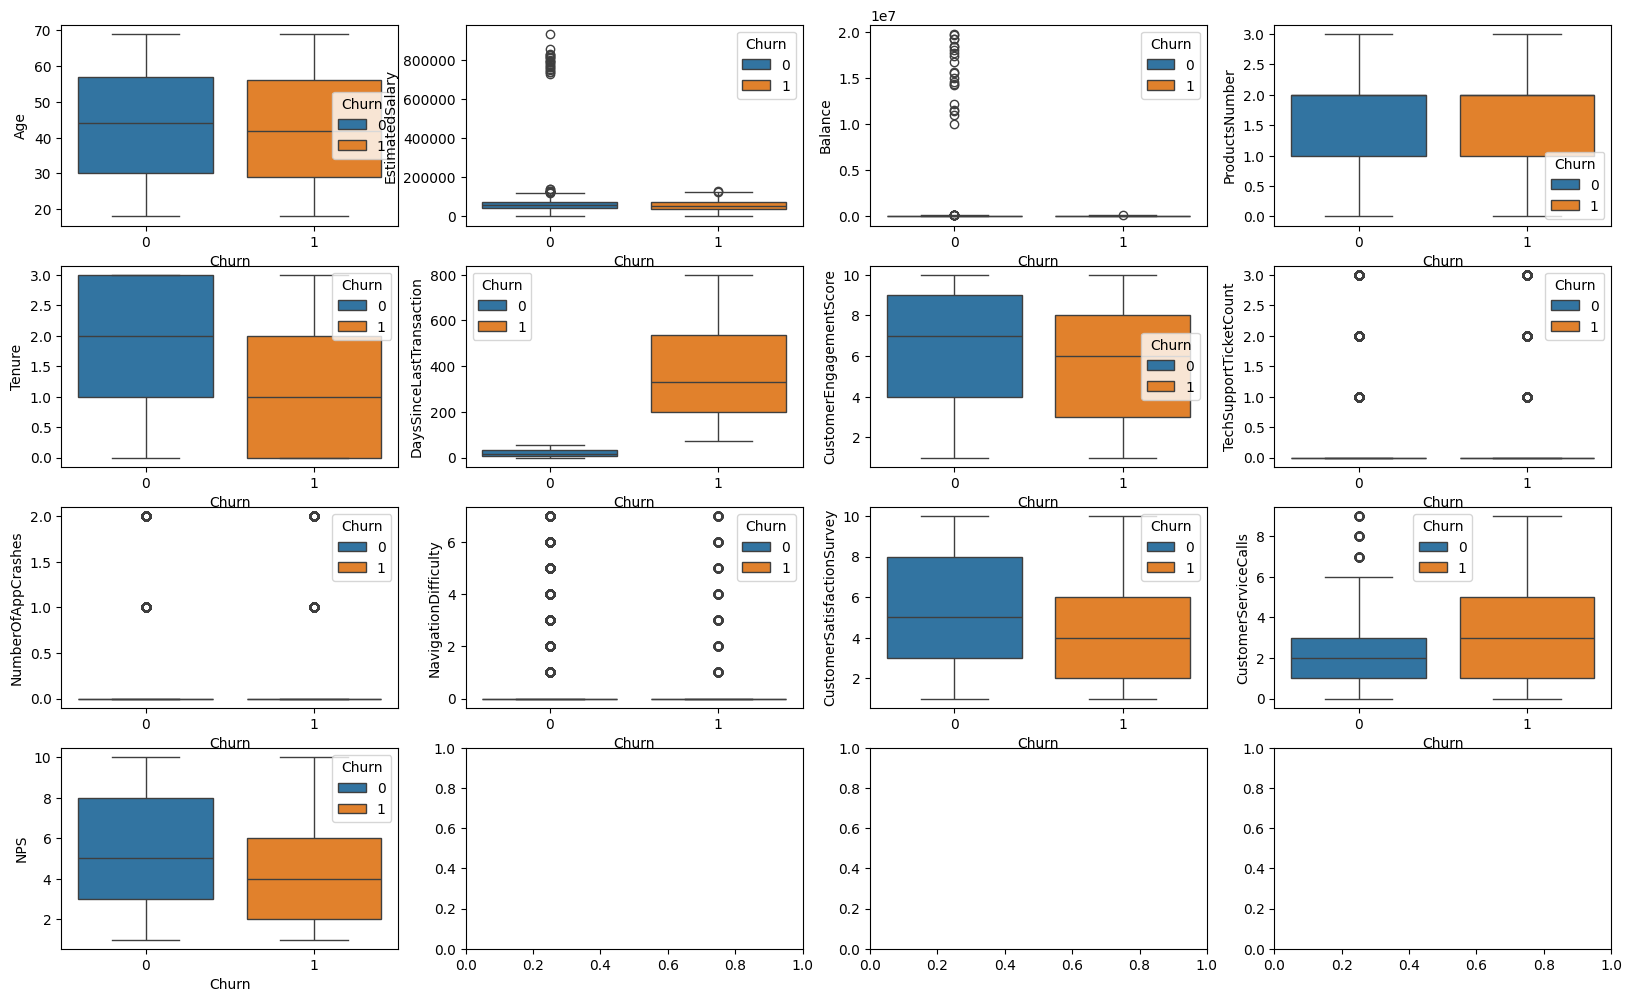

In [46]:
#eda - looking at continuous features
fig, axarr = plt.subplots(4, 4, figsize=(20, 12))
sns.boxplot(y='Age',x = 'Churn', hue = 'Churn',data = df, ax=axarr[0][0])
sns.boxplot(y='EstimatedSalary',x = 'Churn', hue = 'Churn',data = df , ax=axarr[0][1])
sns.boxplot(y='Balance',x = 'Churn', hue = 'Churn',data = df, ax=axarr[0][2])
sns.boxplot(y='ProductsNumber',x = 'Churn', hue = 'Churn',data = df, ax=axarr[0][3])
sns.boxplot(y='Tenure',x = 'Churn', hue = 'Churn',data = df, ax=axarr[1][0])
sns.boxplot(y='DaysSinceLastTransaction',x = 'Churn', hue = 'Churn',data = df, ax=axarr[1][1])
sns.boxplot(y='CustomerEngagementScore',x = 'Churn', hue = 'Churn',data = df, ax=axarr[1][2])
sns.boxplot(y='TechSupportTicketCount',x = 'Churn', hue = 'Churn',data = df, ax=axarr[1][3])
sns.boxplot(y='NumberOfAppCrashes',x = 'Churn', hue = 'Churn',data = df, ax=axarr[2][0])
sns.boxplot(y='NavigationDifficulty',x = 'Churn', hue = 'Churn',data = df, ax=axarr[2][1])
sns.boxplot(y='CustomerSatisfactionSurvey',x = 'Churn', hue = 'Churn',data = df, ax=axarr[2][2])
sns.boxplot(y='CustomerServiceCalls',x = 'Churn', hue = 'Churn',data = df, ax=axarr[2][3])
sns.boxplot(y='NPS',x = 'Churn', hue = 'Churn',data = df, ax=axarr[3][0])

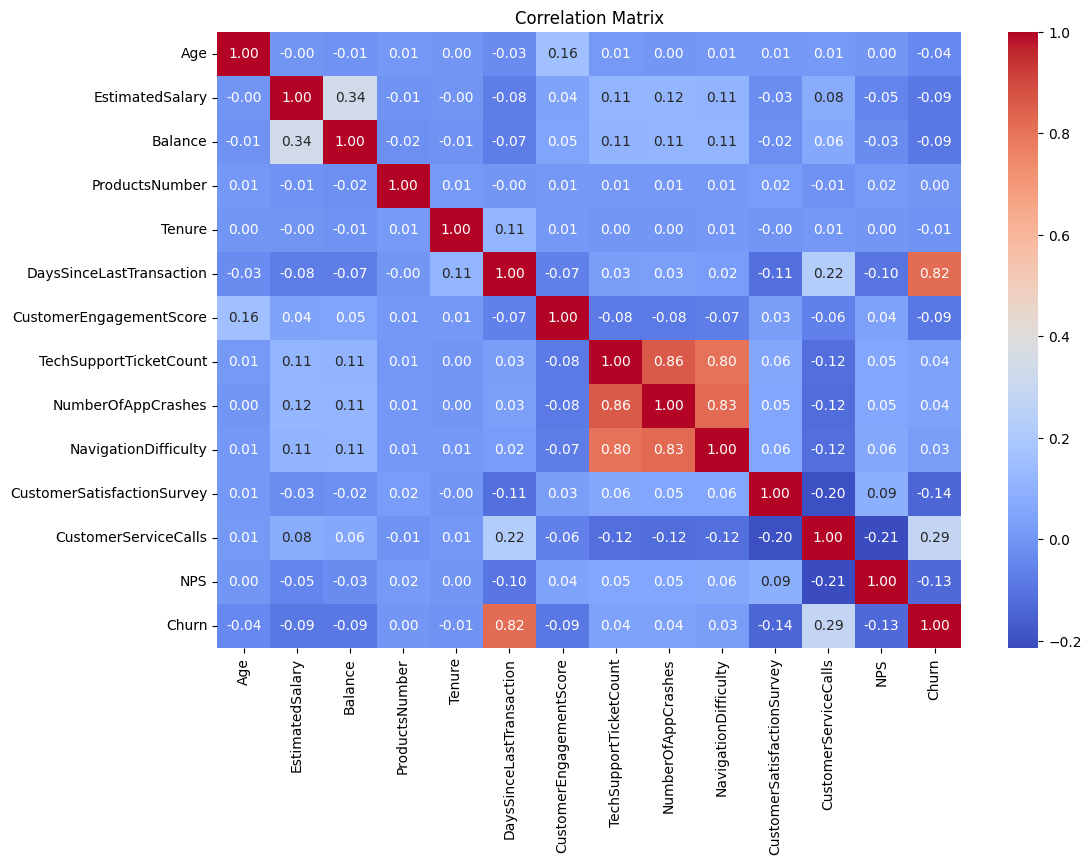

In [80]:
#correlation matrix

#drop non-numeric columns
categorical_vars = ['EmploymentStatus', 'HousingStatus', 'ActiveMember', 'DebitCard', 'SavingsAccount', 'FlexiLoan', 'UserFrustration']
numeric_df = data_cleaned.select_dtypes(include=['float64', 'int64'])
numeric_df = numeric_df.drop(columns=categorical_vars)

#calculate the correlation matrix
correlation_matrix = numeric_df.corr()

#plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

rebalance data and build models 

In [57]:
# Split the data into training and testing sets before any preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

    # Create a column transformer to apply the transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
        ])
X_preprocessed = preprocessor.fit_transform(X)
joblib.dump(preprocessor, 'preprocessor.pkl')
# Apply preprocessing to the training data
X_train_preprocessed = preprocessor.fit_transform(X_train)
# Apply the same preprocessing to the test data
X_test_preprocessed = preprocessor.transform(X_test)
# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_preprocessed, y_train)
print("Shape of X after SMOTE:", X_train_resampled.shape)
print("Shape of y after SMOTE:", y_train_resampled.shape)

Shape of X after SMOTE: (9600, 24)
Shape of y after SMOTE: (9600,)


In [ ]:
# Set random seed for reproducibility later on in hyperparameter tuning
random_seed = 42

# Initialize classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(random_state=random_seed),
    # "Logistic Regression": LogisticRegression(random_state=random_seed),
    "Support Vector Machine": SVC(random_state=random_seed),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "Gradient Boosting": GradientBoostingClassifier(random_state=random_seed)
    }

In [59]:
# Dictionary that stores evaluation metrics of models
'''
Key: Model name
Value: A list containing the following metrics:
  - True Positive Rate
  - False Positive Rate
  - True Negative Rate
  - False Negative Rate
  - F1 Score
  - ROC AUC Score
  - Precision Score
'''
model_results = {}

In [60]:
# Function to view classification report

def clf_report(model_name, y_pred):
    '''
    Prints the classification report of a model for multi-class classification.

    Inputs:
      model_name: name of the model
      y_pred: array of predicted class labels
    '''
    print(model_name)

    # Calculating scores for multi-class classification
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("Accuracy score:", round(accuracy, 4))

    # Only calculate ROC AUC if y_pred is not just labels (requires probability scores)
    # print("ROC AUC score:", round(metrics.roc_auc_score(y_test, y_pred, average='macro', multi_class='ovo'), 4))

    f1 = metrics.f1_score(y_test, y_pred, average='macro')
    print("F1 score:", round(f1, 4))

    # Confusion matrix
    matrix = metrics.confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(matrix)

    print(metrics.classification_report(y_test, y_pred))

    # Display the confusion matrix graphically
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot()
    plt.show()


1 2 3 4 5 6 7 8 9 

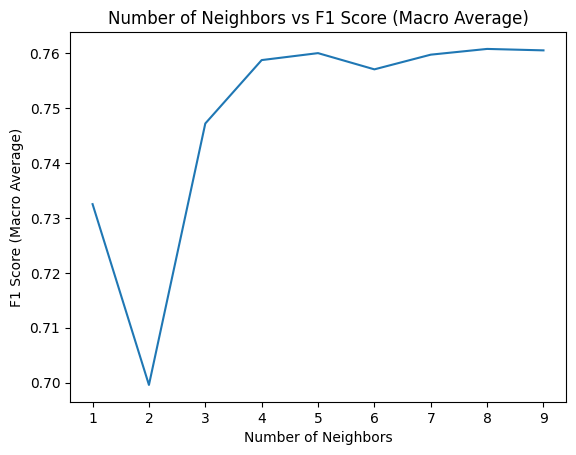

In [64]:
error = []  # This will store the average F1 scores for each k
k = range(1, 10)  # Testing k from 1 to 9

for i in k:
    print(i, end=" ")
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_resampled, y_train_resampled)  # Assuming X_train_resampled and y_train_resampled are correctly prepared
    y_pred = knn.predict(X_test_preprocessed)  # Predicting with the test set
    
    # Calculate the F1 score for multi-class classification
    # The 'average' parameter can be set to 'macro', 'micro', or 'weighted' depending on how you want to aggregate the scores
    # 'macro' averages the F1 scores of each class without taking label imbalance into account
    # 'micro' calculates the total true positives, false negatives, and false positives and computes a global F1 score
    # 'weighted' averages the F1 scores of each class, weighting them by the number of true instances for each class
    f1 = metrics.f1_score(y_test, y_pred, average='macro')
    error.append(f1)  # Append the calculated F1 score to the list

# Plotting the results
plt.plot(k, error)
plt.title('Number of Neighbors vs F1 Score (Macro Average)')
plt.xlabel('Number of Neighbors')
plt.ylabel('F1 Score (Macro Average)')
plt.show()

Random Forest
Accuracy score: 0.8732
F1 score: 0.873
Confusion Matrix:
[[268   3  10   3   8   0]
 [  0 299   2   0   0   0]
 [  0   4 215  67 106   0]
 [  3   4   0 391   0   0]
 [  9   3  31   0 242   0]
 [  0   0   0   0   0 328]]
                       precision    recall  f1-score   support

CustomerServiceIssues       0.96      0.92      0.94       292
  FinanciallyStrained       0.96      0.99      0.97       301
              General       0.83      0.55      0.66       392
                Loyal       0.85      0.98      0.91       398
        Opportunistic       0.68      0.85      0.76       285
     TechDifficulties       1.00      1.00      1.00       328

             accuracy                           0.87      1996
            macro avg       0.88      0.88      0.87      1996
         weighted avg       0.88      0.87      0.87      1996



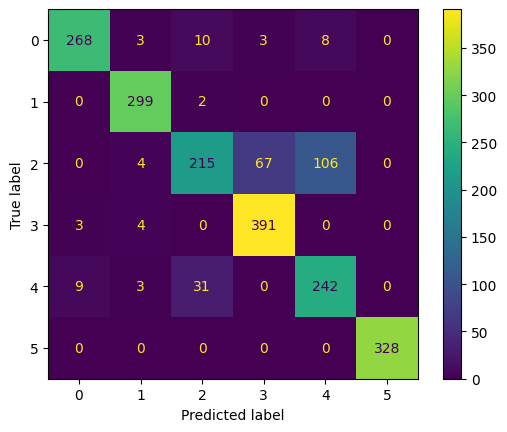

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression
Accuracy score: 0.8377
F1 score: 0.8403
Confusion Matrix:
[[254   4   9   9  16   0]
 [  0 299   1   1   0   0]
 [ 10   8 218  77  79   0]
 [  8   6  31 350   3   0]
 [ 12   5  40   5 223   0]
 [  0   0   0   0   0 328]]
                       precision    recall  f1-score   support

CustomerServiceIssues       0.89      0.87      0.88       292
  FinanciallyStrained       0.93      0.99      0.96       301
              General       0.73      0.56      0.63       392
                Loyal       0.79      0.88      0.83       398
        Opportunistic       0.69      0.78      0.74       285
     TechDifficulties       1.00      1.00      1.00       328

             accuracy                           0.84      1996
            macro avg       0.84      0.85      0.84      1996
         weighted avg       0.84      0.84      0.83      1996



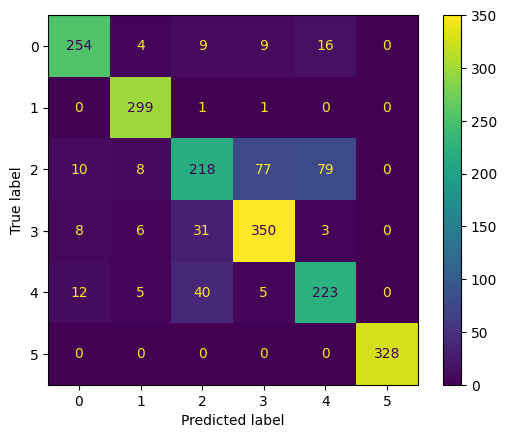


Support Vector Machine
Accuracy score: 0.8412
F1 score: 0.8388
Confusion Matrix:
[[254   4   6  13  15   0]
 [  0 301   0   0   0   0]
 [  8   8 183  89 104   0]
 [  9   9   3 377   0   0]
 [ 12   6  30   1 236   0]
 [  0   0   0   0   0 328]]
                       precision    recall  f1-score   support

CustomerServiceIssues       0.90      0.87      0.88       292
  FinanciallyStrained       0.92      1.00      0.96       301
              General       0.82      0.47      0.60       392
                Loyal       0.79      0.95      0.86       398
        Opportunistic       0.66      0.83      0.74       285
     TechDifficulties       1.00      1.00      1.00       328

             accuracy                           0.84      1996
            macro avg       0.85      0.85      0.84      1996
         weighted avg       0.85      0.84      0.83      1996



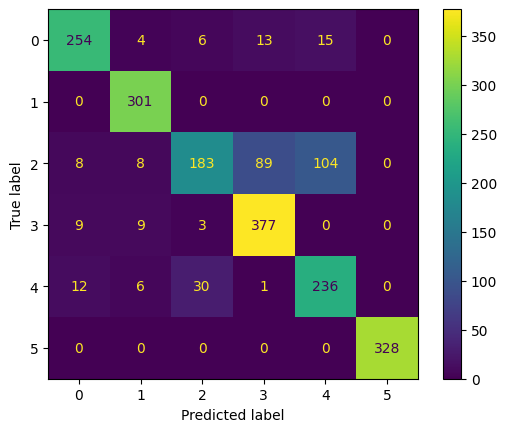


KNN
Accuracy score: 0.764
F1 score: 0.7598
Confusion Matrix:
[[240   6  16  14  16   0]
 [  1 298   1   1   0   0]
 [ 19  22 162  96  93   0]
 [ 11  14  28 342   3   0]
 [ 25  12  76  17 155   0]
 [  0   0   0   0   0 328]]
                       precision    recall  f1-score   support

CustomerServiceIssues       0.81      0.82      0.82       292
  FinanciallyStrained       0.85      0.99      0.91       301
              General       0.57      0.41      0.48       392
                Loyal       0.73      0.86      0.79       398
        Opportunistic       0.58      0.54      0.56       285
     TechDifficulties       1.00      1.00      1.00       328

             accuracy                           0.76      1996
            macro avg       0.76      0.77      0.76      1996
         weighted avg       0.75      0.76      0.75      1996



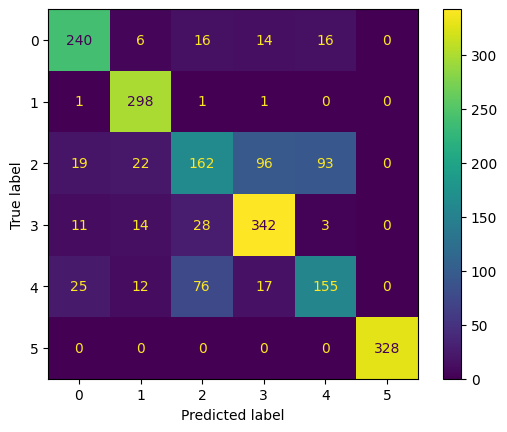


Gradient Boosting
Accuracy score: 0.8783
F1 score: 0.8777
Confusion Matrix:
[[272   2  10   5   3   0]
 [  0 300   1   0   0   0]
 [  0   4 213  67 108   0]
 [  3   3   0 392   0   0]
 [ 11   3  23   0 248   0]
 [  0   0   0   0   0 328]]
                       precision    recall  f1-score   support

CustomerServiceIssues       0.95      0.93      0.94       292
  FinanciallyStrained       0.96      1.00      0.98       301
              General       0.86      0.54      0.67       392
                Loyal       0.84      0.98      0.91       398
        Opportunistic       0.69      0.87      0.77       285
     TechDifficulties       1.00      1.00      1.00       328

             accuracy                           0.88      1996
            macro avg       0.89      0.89      0.88      1996
         weighted avg       0.88      0.88      0.87      1996



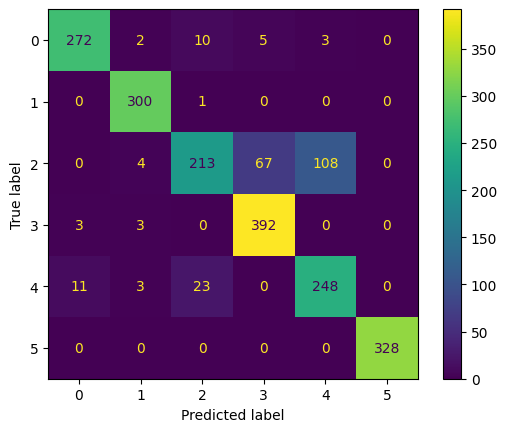

In [66]:
# Train each model
for name, clf in classifiers.items():
    # Train the model
    clf.fit(X_train_resampled, y_train_resampled)

    # Make predictions on the test set
    y_pred = clf.predict(X_test_preprocessed)

    # Evaluate the model
    clf_report(name, y_pred)
    print()

    # Separator
    print(''.join(['='] * 60))
    print(''.join(['='] * 60))

gradient boosting hyperparameter tuning

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 5/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8;, score=0.889 total time=  17.0s
[CV 4/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8;, score=0.881 total time=  19.1s
[CV 1/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8;, score=0.888 total time=  19.7s
[CV 2/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8;, score=0.873 total time=  19.7s
[CV 3/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=0.8;, score=0.874 total time=  19.9s
[CV 3/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100, subsample=1.0;, score=0.876 total time=  24.2s
[CV 2/5] END learning_rate=

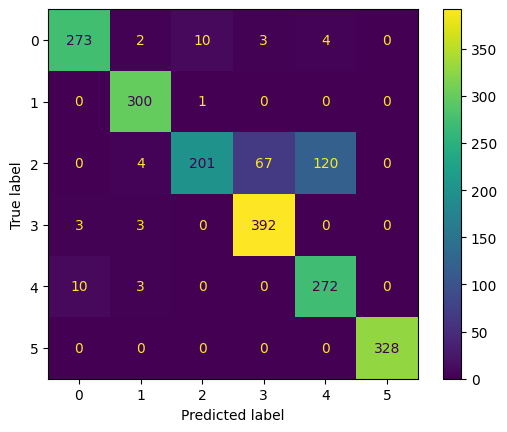

In [68]:
import joblib
np.random.seed(42)
param_grid = {
    "Gradient Boosting": {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'subsample': [0.8, 1.0]
}
}
classifiers_2 = {
    "Gradient Boosting": GradientBoostingClassifier(random_state=random_seed)
    }
for name, clf in classifiers_2.items():
    param_grid = param_grid[name]
    grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3) # parallelize the hyperparameter search to make it faster
    grid_search.fit(X_train_resampled, y_train_resampled)

    print(f"Best parameters for {name}: {grid_search.best_params_}")
    best_clf = grid_search.best_estimator_
    # Optionally save the best model
    joblib.dump(best_clf, f'{name}_best_model.pkl')

    # Print the parameters of the best model
    print(f"Parameters of the best model: {best_clf.get_params()}")

    # Evaluate the best model
    y_pred = best_clf.predict(X_test_preprocessed)
    clf_report(name, y_pred)
    print()

    # Separator
    print(''.join(['='] * 60))
    print(''.join(['='] * 60))

deep learning model - feed forward neuralnetwork 

In [87]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
encoder = LabelEncoder()

# Fit the encoder to the training data and transform both training and test data
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)
# Define the model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(set(y)), activation='softmax')  # Output layer: one neuron per class
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with integer-encoded labels
history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Deep Learning Model Accuracy: {accuracy}")

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 889us/step - accuracy: 0.3963 - loss: 1.5133 - val_accuracy: 0.7833 - val_loss: 0.5560
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - accuracy: 0.7109 - loss: 0.7030 - val_accuracy: 0.8197 - val_loss: 0.4360
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - accuracy: 0.7662 - loss: 0.5846 - val_accuracy: 0.8134 - val_loss: 0.4169
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - accuracy: 0.7679 - loss: 0.5452 - val_accuracy: 0.8228 - val_loss: 0.3964
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - accuracy: 0.7930 - loss: 0.5115 - val_accuracy: 0.8359 - val_loss: 0.3826
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - accuracy: 0.7979 - loss: 0.4695 - val_accuracy: 0.8284 - val_loss: 0.3821
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 572us/step - accuracy: 0.8051 - loss: 0.4750 - val_accuracy: 0.8410 - val_loss: 0.3688
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.8061 - loss: 0.4411 - val_accurac

In [88]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define a function to create and compile the model with given hyperparameters
def create_and_compile_model(learning_rate, dropout_rate):
    model = Sequential([
        Dense(128, activation='relu', input_dim=X_train.shape[1]),
        Dropout(dropout_rate),
        Dense(64, activation='relu'),
        Dropout(dropout_rate),
        Dense(len(set(y_train_encoded)), activation='softmax')  # Using set on y_train_encoded to count unique classes
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Define your hyperparameters to test
learning_rates = [0.001, 0.01, 0.1]
dropout_rates = [0.3, 0.5, 0.7]
epochs = 50
batch_size = 32

# Manual grid search
best_score = 0
best_params = {}

for lr in learning_rates:
    for dr in dropout_rates:
        print(f"Testing model with learning rate: {lr} and dropout rate: {dr}")
        model = create_and_compile_model(lr, dr)
        history = model.fit(X_train, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)
        val_accuracy = max(history.history['val_accuracy'])
        print(f"Validation Accuracy: {val_accuracy:.4f}")
        
        if val_accuracy > best_score:
            best_score = val_accuracy
            best_params = {'learning_rate': lr, 'dropout_rate': dr}


Testing model with learning rate: 0.001 and dropout rate: 0.3
Validation Accuracy: 0.8616
Testing model with learning rate: 0.001 and dropout rate: 0.5
Validation Accuracy: 0.8679
Testing model with learning rate: 0.001 and dropout rate: 0.7
Validation Accuracy: 0.8616
Testing model with learning rate: 0.01 and dropout rate: 0.3
Validation Accuracy: 0.8547
Testing model with learning rate: 0.01 and dropout rate: 0.5
Validation Accuracy: 0.8466
Testing model with learning rate: 0.01 and dropout rate: 0.7
Validation Accuracy: 0.8322
Testing model with learning rate: 0.1 and dropout rate: 0.3
Validation Accuracy: 0.3782
Testing model with learning rate: 0.1 and dropout rate: 0.5
Validation Accuracy: 0.3694
Testing model with learning rate: 0.1 and dropout rate: 0.7
Validation Accuracy: 0.3601


In [89]:

print("Best Validation Accuracy: {:.4f}".format(best_score))
print("Best Parameters:", best_params)


Best Validation Accuracy: 0.8679
Best Parameters: {'learning_rate': 0.001, 'dropout_rate': 0.5}
